# The Problem
As solar technology gets better and better, it will be crucial in the future to be able to predict the energy output of a given solar panel installation. This can be affected by solar panel technology and weather.

A family friend recently bought some property in Oregon. He was told that it was a premium place for solar panels. I wanted to test this claim and use machine learning to predict the actual energy output (not the available energy) of solar panels in this location. Namely, I wanted to answer the following:

- How much energy can we get from solar panels placed on the property?
- Can we use "easy" predictors like those given in a weather forecast to accurately predict the energy output?

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# The Data
Christil K. Pasion wrote a thesis on this problem for the Air Force Institute of Technology and left the pre-processed data open and available. The paper is in the file `Pasion-paper.pdf`. 

Basically, the team setup solar panels across the world and logged the output (in Watts) every 15 minutes. The temperature and humidity were also recorded at the site. Other associated weather data came from the nearest NOAA weather station available.

During cleaning of the data, the author cut a lot of it out for various reasons. This left only the data from the polycrystalline panels. However, there is still over a year's worth of data from 12 different locations in the United States with a grand total of 21,045 complete data points.

One confusion about the data is it is unclear the rated wattage of the panels are. In the materials description, the author states the monocrystalline panels are 50 watts and the polycrystalline panels are 25 watts. Later on when describing how they cut out data, the author states the opposite: "the monocrystalline panel at the United States Air Force Academy, in Colorado, recorded data above 400 watts, much outside of the panel’s 25-watt rating." I looked online for all four combinations (mono-25W, poly-25W, mono-50W, poly-50W) of these products and they are all available from Amazon. After further reading the chapter, I am going to assume the rated output is 50 watts and these are polycrystalline panels.

In [2]:
data = pd.read_csv("raw-data-Pasion.csv")
data.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [4]:
data.describe()

,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
count,2.104500e+04,21045.000000,21045.000000,21045.000000,21045.000000,2.104500e+04,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000
mean,2.017720e+07,1267.483725,38.213823,-108.593678,798.843668,2.017718e+11,6.565883,12.627845,37.121941,29.285117,12.978583,10.318318,9.700071,925.944747,515.966785
std,4.579585e+03,167.602767,6.323761,16.364130,770.681794,4.579846e+07,2.983958,1.672952,23.823011,12.366820,7.123255,6.385030,1.351949,85.215659,301.903379
min,2.017052e+07,1000.000000,20.890000,-156.440000,1.000000,2.017050e+11,1.000000,10.000000,0.000000,-19.981770,0.257330,0.000000,0.000000,781.700000,0.000000
25%,2.017111e+07,1100.000000,38.160000,-117.260000,2.000000,2.017110e+11,4.000000,11.000000,17.529300,21.915280,6.404570,6.000000,10.000000,845.500000,140.000000
50%,2.018032e+07,1300.000000,38.950000,-111.180000,458.000000,2.018030e+11,7.000000,13.000000,33.123780,30.289150,13.798700,9.000000,10.000000,961.100000,722.000000
75%,2.018062e+07,1400.000000,41.150000,-104.710000,1370.000000,2.018060e+11,9.000000,14.000000,52.593990,37.474670,18.863650,14.000000,10.000000,1008.900000,722.000000
max,2.018100e+07,1545.000000,47.520000,-80.110000,1947.000000,2.018100e+11,12.000000,15.000000,99.987790,65.738370,34.285020,49.000000,10.000000,1029.500000,722.000000


From the above table, it looks like visibility doesn't have many unique values as most of them are 10 miles indicating very high visibility. This is the highest allowed value reported by NOAA. No missing data though!

## Cleaning
Since the author of the data already did most of the hard cleaning, it will be relatively easy and straightforward. 

First, I want to change the `Date` and `Time` columns. I will combine these two and convert from integers to an actual datetime object. 

Second, there are going to be some columns that are not very useful. `YRMODAHRMI` is just another representation of the datetime but that is taken care of. Similarly, I will drop other columns that contain date and time information such as `Month` and `Hour`. `Season` is also useless for what I am doing since it can be inferred from the date.

The other cleaning tasks I will do are convert the cloud ceiling measurement to kilometers. This is the standard unit for NOAA and the maximum measurement is 22 kilometers. Finally, I will reorder the columns to put the target (or at least the proxy for the target) to the front, per convention.

In summary, the cleaning tasks involved:
- convert cloud ceiling from feet to meters
- drop useless columns
- convert date and time from int to datetime
- reorder columns

In [5]:
dirty_df = data.copy()

dtype_converter = {
    "Date": str,
    "Time": str
}
dirty_df = dirty_df.astype(dtype_converter)

dirty_df["datetime"] = dirty_df["Date"] + dirty_df["Time"]
dirty_df["datetime"] = pd.to_datetime(dirty_df["datetime"], format="%Y%m%d%H%M")

dirty_df["Cloud.Ceiling"] = dirty_df["Cloud.Ceiling"]*100/3281 # hundreds of feet -> kilometers

dirty_df = dirty_df.drop(["YRMODAHRMI", "Date", "Time", "Month", "Season", "Hour"], axis=1)

dirty_df.columns.values

array(['Location', 'Latitude', 'Longitude', 'Altitude', 'Humidity',
       'AmbientTemp', 'PolyPwr', 'Wind.Speed', 'Visibility', 'Pressure',
       'Cloud.Ceiling', 'datetime'], dtype=object)

In [6]:
dirty_df = dirty_df[['PolyPwr', 'Location', 'Latitude', 'Longitude', 'Altitude',
       'Humidity', 'AmbientTemp', 'Wind.Speed',
       'Visibility', 'Pressure', 'Cloud.Ceiling', 'datetime']]
dirty_df = dirty_df.set_index("datetime")

In [7]:
df = dirty_df.copy()
df.describe()

,PolyPwr,Latitude,Longitude,Altitude,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
count,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000
mean,12.978583,38.213823,-108.593678,798.843668,37.121941,29.285117,10.318318,9.700071,925.944747,15.725900
std,7.123255,6.323761,16.364130,770.681794,23.823011,12.366820,6.385030,1.351949,85.215659,9.201566
min,0.257330,20.890000,-156.440000,1.000000,0.000000,-19.981770,0.000000,0.000000,781.700000,0.000000
25%,6.404570,38.160000,-117.260000,2.000000,17.529300,21.915280,6.000000,10.000000,845.500000,4.266992
50%,13.798700,38.950000,-111.180000,458.000000,33.123780,30.289150,9.000000,10.000000,961.100000,22.005486
75%,18.863650,41.150000,-104.710000,1370.000000,52.593990,37.474670,14.000000,10.000000,1008.900000,22.005486
max,34.285020,47.520000,-80.110000,1947.000000,99.987790,65.738370,49.000000,10.000000,1029.500000,22.005486


## Feature Engineering
As of now, the data is sparse with measurements every 15 minutes with many missing in a day. For this project, I would like to be able to predict the daily energy output. Therefore, I will transform the features into daily energy output.

This is done by grouping the data into dates and then grouping those by location. For each unique location on a unique date, the daily output is calculated following:
$$E_{daily} = \int_{t_i}^{t_f}Pdt$$
where $P$ is the power output and $t$ is time. This gives the total energy output over the given time span.

TODO: insert chart

For this case, I wil approximate the integral numerically using the simple trapezoid formula. Instead of coding it by hand, numpy comes with a `trapz` method.

This energy output is specifically for 50W panels. To be able to scale it to a larger panel application, this energy output needs to be dimensionless. This is done by dividing the actual energy output by the rated energy output. I will call this efficiency. If an efficiency is predicted, you can simply multiply it by the solar panel rating to get the estimated actual energy output. Therefore, I will use this efficiency as my target variable.

In [8]:
d = {
    "date": [],
    "location": [],
    "daily_energy": [],
    "operation_time": [],
    "ideal_daily_energy": [],
    "Latitude": [],
    "Longitude": [],
    "Altitude": [],
    "Humidity": [],
    "AmbientTemp": [],
    "Wind.Speed": [],
    "Visibility": [],
    "Pressure": [],
    "Cloud.Ceiling": []
    }

for unique_date in np.unique(df.index.date):
    for unique_location in df.loc[str(unique_date)]["Location"].unique():

        matching_date_df = df.loc[str(unique_date)]
        matching_date_and_loc = matching_date_df[matching_date_df["Location"]==unique_location]

        operation_time = matching_date_and_loc.index.max() - matching_date_and_loc.index.min()
        operation_time = operation_time.total_seconds()/3600 # hours
        if operation_time == 0:
            continue # skip if not operating that day
        ideal_output = operation_time * 50 # 50 Watt rated panel

        x = matching_date_and_loc.sort_index().index.values.astype(np.int64)//10 ** 9/3600
        y = matching_date_and_loc.sort_index()["PolyPwr"]
        daily_output = np.trapz(y, x) # Watt-hours unit

        d["date"].append(unique_date)
        d["location"].append(unique_location)
        d["operation_time"].append(operation_time)
        d["daily_energy"].append(daily_output)
        d["ideal_daily_energy"].append(ideal_output)

        for feature in df.drop(["Location", "PolyPwr"], axis=1).columns.values:
            d[feature].append(matching_date_and_loc[feature].mean())


daily_df = pd.DataFrame(d)
daily_df.head()

,date,location,daily_energy,operation_time,ideal_daily_energy,Latitude,Longitude,Altitude,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,2017-05-23,JDMT,78.134520,4.00,200.0,26.98,-80.11,2.0,36.097718,38.398038,13.750000,10.000000,1013.675000,5.242304
1,2017-05-24,JDMT,84.751535,5.00,250.0,26.98,-80.11,2.0,39.012452,39.214906,18.800000,10.000000,1009.100000,17.909174
2,2017-05-25,JDMT,55.436922,5.75,287.5,26.98,-80.11,2.0,87.121582,28.953932,10.666667,7.583333,1011.566667,1.285177
3,2017-05-25,USAFA,88.814154,5.50,275.0,38.95,-104.83,1947.0,10.343279,35.505829,16.428571,10.000000,786.942857,15.583228
4,2017-05-26,JDMT,121.932250,5.00,250.0,26.98,-80.11,2.0,39.345295,34.868848,7.166667,10.000000,1017.550000,18.668089


In [9]:
daily_df["daily_efficiency"] = daily_df["daily_energy"]/daily_df["ideal_daily_energy"]

I also want to extract the month and day of the month to use as features in the model.

In [10]:
daily_df["date"] = pd.to_datetime(daily_df["date"], format="%Y-%m-%d")
daily_df["month"] = daily_df["date"].dt.month
daily_df["day"] = daily_df["date"].dt.day

In [11]:
daily_df.describe()

,daily_energy,operation_time,ideal_daily_energy,Latitude,Longitude,Altitude,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling,daily_efficiency,month,day
count,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000
mean,62.218988,4.481505,224.075237,38.125882,-108.456226,758.036851,36.559933,29.196217,10.307284,9.752448,930.608966,16.145532,0.269390,6.579564,15.758794
std,31.027227,0.992497,49.624829,6.546400,16.766465,756.225700,21.241312,11.427519,5.483647,0.988677,83.682765,7.602125,0.119932,3.071649,8.850453
min,0.413411,0.250000,12.500000,20.890000,-156.440000,1.000000,0.067139,-17.170753,0.000000,0.266667,782.000000,0.053337,0.009149,1.000000,1.000000
25%,37.954739,4.000000,200.000000,38.160000,-117.260000,2.000000,19.210434,22.464141,6.400000,10.000000,852.356429,10.226303,0.175739,4.000000,8.000000
50%,65.544651,5.000000,250.000000,38.820000,-111.180000,458.000000,34.356690,30.746409,9.125000,10.000000,963.431250,22.005486,0.286641,7.000000,16.000000
75%,87.188323,5.000000,250.000000,41.150000,-95.750000,1370.000000,50.099755,37.635068,13.600000,10.000000,1009.775000,22.005486,0.365881,9.000000,23.750000
max,139.395830,5.750000,287.500000,47.520000,-80.110000,1947.000000,99.987790,58.385430,38.000000,10.000000,1028.800000,22.005486,0.564822,12.000000,31.000000


In [12]:
model_df = daily_df.drop([
    "operation_time", "daily_energy", "ideal_daily_energy", 
    "location", "Visibility", "date"], axis=1)

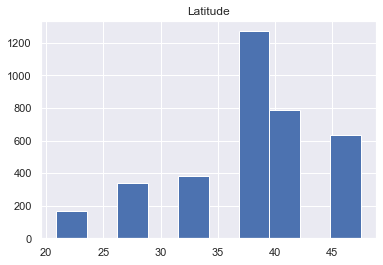

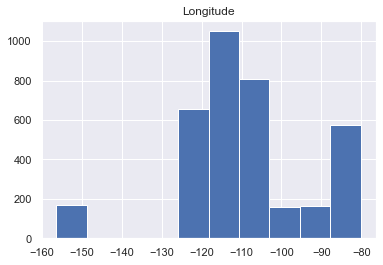

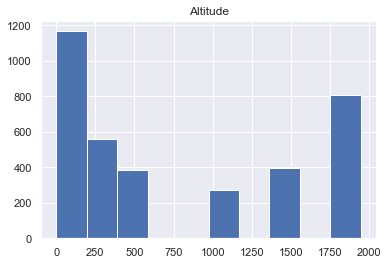

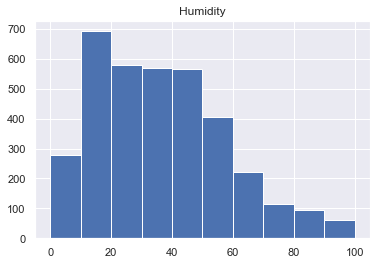

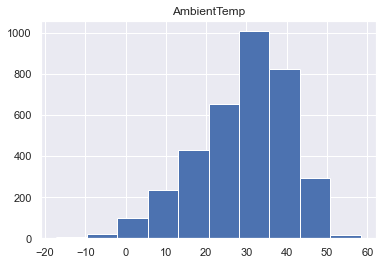

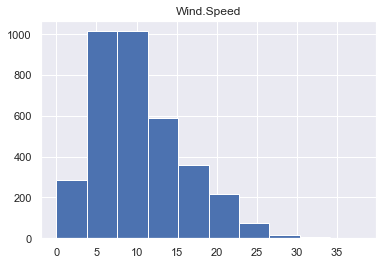

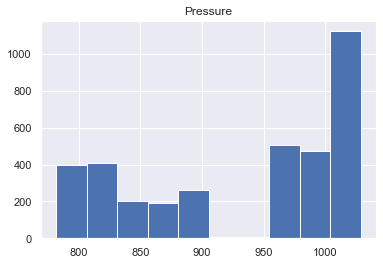

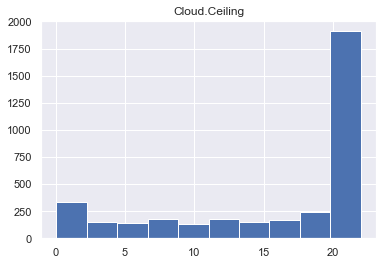

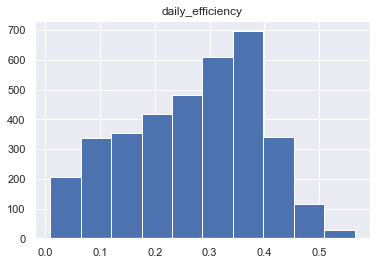

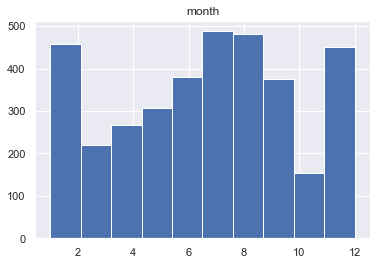

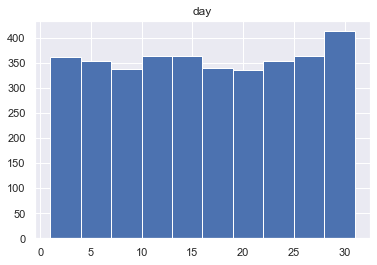

In [13]:
for col in model_df.columns.values:
    plt.hist(model_df[col])
    plt.title(col)
    plt.show()

## Feature Selection

In [14]:
X = model_df.drop(["daily_efficiency"], axis=1)
y = model_df["daily_efficiency"]

In [15]:
best_features = SelectKBest(score_func=mutual_info_regression, k=5).fit(X, y)

dfscores = pd.DataFrame(best_features.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))

           Specs     Score
4    AmbientTemp  0.356017
8          month  0.264948
0       Latitude  0.245468
1      Longitude  0.244834
6       Pressure  0.202575
2       Altitude  0.195668
7  Cloud.Ceiling  0.165019
3       Humidity  0.132042
5     Wind.Speed  0.019101
9            day  0.000000


In [16]:
selection_mask = best_features.get_support()
X_selected = X[X.columns[selection_mask]]

# The Model

Models to try:
1. Decision Tree
2. Random Forest
3. Multiple Linear Regression

I am using mean absolute error as an evaluation metric defined as:
$$MAE = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)$$

Mean absolute error is good because it is intuitive. If the mean absolute error is -0.5, that means the prediction is, on average, 0.5 too low.

For each model, I will get a cross validation score because the sample size is relatively small. This will return the best *validation* score rather than the best *training* score. This is what will be used to compare the various models.

## Split and Shuffle

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3)

In [18]:
model_scores = {}

## Model 1: Decision Tree Regression
This model is being used because it is easy to implement, non-linearity doesn't affect performance, and I wanted to learn more about decision trees. However, decision trees are prone to overfitting because of their simplicity.

In [21]:
pipeline = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("regression", DecisionTreeRegressor()),
])

model_scores["decision_tree"] = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_absolute_error", cv=5).mean()
print(model_scores["decision_tree"])

-0.06403271761442034


## Model 2: Random Forest
The random forest model uses many different decision trees and combines their votes to make a prediction. This is an ensemble method and greatly reduces risk of overfitting when using a decision tree. 

In [22]:
pipeline = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("regression", RandomForestRegressor())
])

model_scores["random_forest"] = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_absolute_error", cv=5).mean()
print(model_scores["random_forest"])

-0.04937434554358567


## Model 3: Multiple Linear Regression
A simple statistical model but we need to check assumptions along the way.

### Assumption 1: Linearity

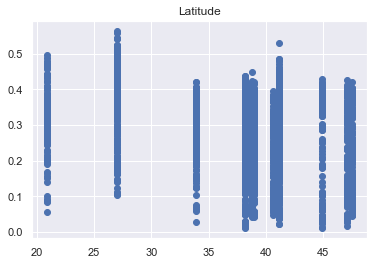

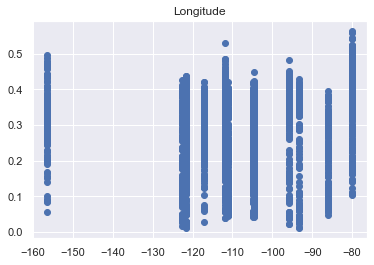

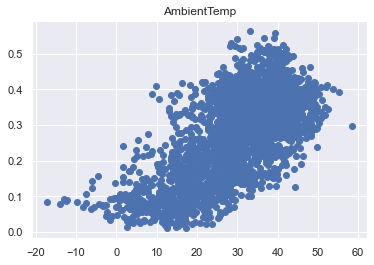

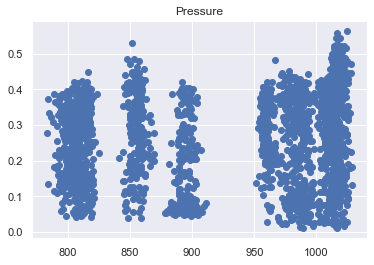

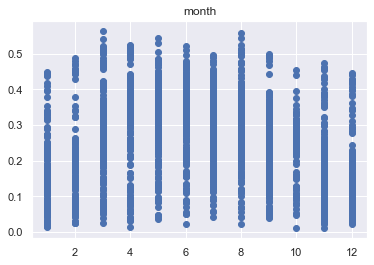

In [23]:
for col in X_train.columns.values:
    plt.scatter(X_train[col], y_train)
    plt.title(col)
    plt.show()

All independent variables are either close to linear or random (not non-linear). Let's proceed to the next assumption.

### Assumption 2: No multicollinearity

<AxesSubplot:>

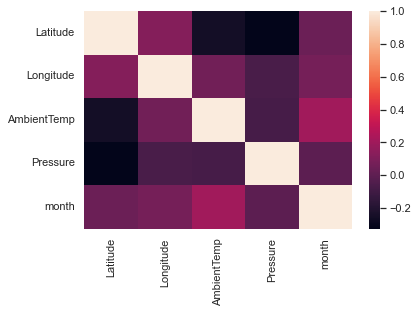

In [24]:
sns.heatmap(X_train.corr())

None of the independent variables are correlated with each other.

### Assumption 3, 4, and 5: Homoscedasticity and normality and no autocorrelation

Residuals should be normally distributed with a mean of zero and a constant variance. Residuals should have no correlation. These will be checked if this model is a candidate for later on and is fitted.

In [25]:
pipeline = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("regression", LinearRegression())
])

model_scores["multiple_linear"] = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_absolute_error", cv=5).mean()
print(model_scores["multiple_linear"])

-0.06643633411088508


## Comparing Models

In [26]:
model_comparison_df = pd.DataFrame.from_dict(model_scores, orient="index", columns=["MAE"])
model_comparison_df.sort_values("MAE", ascending=False)

,MAE
random_forest,-0.049374
decision_tree,-0.064033
multiple_linear,-0.066436


By the selected metric (MAE), random forest did better than the rest. Let's continue with using the random forest model and fine tuning the hyperparameters to obtain the best model.

# The Tuning
For the random forest regression model, the hyperparameters I will tune are:
- n_estimators (number of trees in forest)
- max_features (number of features to consider when looking for best split)

As for values, I will use these for the search:
- n_estimators: 
- max_features: 
- max_depth: 

The tuned model will be compared to a baseline model using the sklearn default values for the `RandomForestRegressor`.

In [28]:
base_pipeline = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("regression", RandomForestRegressor())
])

base_model_score = cross_val_score(base_pipeline, X_train, y_train, scoring="neg_mean_absolute_error", cv=5).mean()
print(base_model_score)

-0.049542188722480986


In [29]:
pipeline = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("regression", RandomForestRegressor())
])

parameter_grid = {
    "regression__n_estimators": [int(x) for x in np.linspace(10, 500, 20)],
    "regression__max_features": [3, 4, 5],
}

search = GridSearchCV(
    pipeline, 
    parameter_grid, 
    cv=5,
    scoring="neg_mean_absolute_error"
    )

In [30]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('regression',
                                        RandomForestRegressor())]),
             param_grid={'regression__max_features': [3, 4, 5],
                         'regression__n_estimators': [10, 35, 61, 87, 113, 138,
                                                      164, 190, 216, 242, 267,
                                                      293, 319, 345, 371, 396,
                                                      422, 448, 474, 500]},
             scoring='neg_mean_absolute_error')

In [31]:
search.best_params_

{'regression__max_features': 3, 'regression__n_estimators': 396}

In [32]:
search.best_score_

-0.04851790364120282

In [33]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__max_features,param_regression__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046481,0.007931,0.004693,0.000918,3,10,"{'regression__max_features': 3, 'regression__n...",-0.048553,-0.051502,-0.051882,-0.048269,-0.051536,-0.050348,0.001590,58
1,0.126313,0.009253,0.007529,0.000430,3,35,"{'regression__max_features': 3, 'regression__n...",-0.046870,-0.051039,-0.051405,-0.047797,-0.049948,-0.049412,0.001788,52
2,0.226178,0.003222,0.012173,0.000495,3,61,"{'regression__max_features': 3, 'regression__n...",-0.046808,-0.049614,-0.050185,-0.046225,-0.050418,-0.048650,0.001771,10
3,0.324182,0.005123,0.016117,0.000601,3,87,"{'regression__max_features': 3, 'regression__n...",-0.046922,-0.049119,-0.050480,-0.046765,-0.050441,-0.048745,0.001629,16
4,0.415774,0.003757,0.019449,0.000938,3,113,"{'regression__max_features': 3, 'regression__n...",-0.046808,-0.049280,-0.050641,-0.046454,-0.050240,-0.048685,0.001738,14
5,0.501925,0.005673,0.024119,0.000791,3,138,"{'regression__max_features': 3, 'regression__n...",-0.046588,-0.049468,-0.050336,-0.046257,-0.050642,-0.048658,0.001868,12
6,0.602269,0.008660,0.027949,0.001173,3,164,"{'regression__max_features': 3, 'regression__n...",-0.046996,-0.049207,-0.050220,-0.046466,-0.049956,-0.048569,0.001546,6
7,0.696613,0.003069,0.032847,0.001190,3,190,"{'regression__max_features': 3, 'regression__n...",-0.046800,-0.049137,-0.050556,-0.046767,-0.050014,-0.048655,0.001594,11
8,0.792855,0.008013,0.037288,0.001402,3,216,"{'regression__max_features': 3, 'regression__n...",-0.046531,-0.049650,-0.050572,-0.046553,-0.050195,-0.048700,0.001786,15
9,0.872153,0.057105,0.037428,0.003625,3,242,"{'regression__max_features': 3, 'regression__n...",-0.046989,-0.049497,-0.050397,-0.046606,-0.050467,-0.048791,0.001668,19


In [48]:
tuned_model_score = search.best_score_
print(tuned_model_score)
percent_change_in_MAE = (abs(tuned_model_score) - abs(base_model_score))/abs(base_model_score)
print(f"Percent mean absolute error change from tuning: {percent_change_in_MAE*100}%")

-0.04851790364120282
Percent mean absolute error change from tuning: -2.0675006649703587%


In [38]:
print(tuned_model_score)
print(base_model_score)

-0.04851790364120282
-0.049542188722480986


Text(0, 0.5, 'Relative Importance')

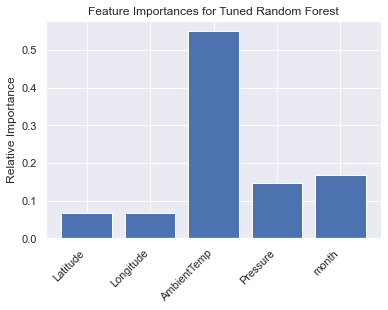

In [39]:
feature_importance = search.best_estimator_.named_steps["regression"].feature_importances_
plt.bar(X_train.columns.values, feature_importance)
plt.xticks(rotation=45, ha="right");
plt.title("Feature Importances for Tuned Random Forest")
plt.ylabel("Relative Importance")

Ambient temperature, month, and pressure have the highest relative importance. Surprisingly, longitude is slightly more important than latitude.

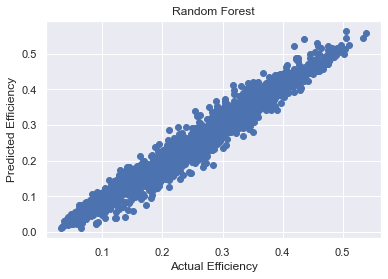

In [40]:
y_predicted = search.predict(X_train)

plt.scatter(y_predicted, y_train)
plt.ylabel("Predicted Efficiency")
plt.xlabel("Actual Efficiency")
plt.title("Random Forest")
plt.show()

In [41]:
with open("tuned_model.pkl", "wb") as f:
    pickle.dump(search.best_estimator_, f)

# The Test

In [42]:
with open("tuned_model.pkl", "rb") as f:
    model = pickle.load(f)

Text(0, 0.5, 'Predicted Efficiency')

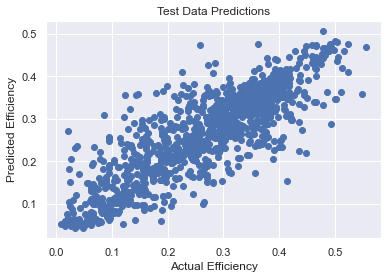

In [43]:
y_test_predicted = model.predict(X_test)

plt.scatter(y_test, y_test_predicted)
plt.title("Test Data Predictions")
plt.xlabel("Actual Efficiency")
plt.ylabel("Predicted Efficiency")

In [45]:
test_mse = mean_absolute_error(y_test, y_test_predicted)
print(f"MSE on Test Data: {test_mse:.3}\nMSE on Train Data: {tuned_model_score:.3}")

MSE on Test Data: 0.0466
MSE on Train Data: -0.0485


In [46]:
test_train_diff = (test_mse - tuned_model_score)/tuned_model_score
print(f"Percent Change From Training to Test: {test_train_diff*100}%")

Percent Change From Training to Test: -196.13983313851836%


# The Future Work
- try other models (boosted trees like XGBoost, Adaboost, etc.)
- download weather forecast for the next x days and spit out a online summary report (streamlit)
- try dropping more unimportant features from random forest model